In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd

# Load data
df = pd.read_csv('/kaggle/input/moviesandtv-csv/Movies_and_TV.csv')

# Preview
print("Raw data sample:")
print(df.head())


Raw data sample:
                        user_id        asin                timestamp
0  AGGZ357AO26RQZVRLGU4D4N52DZQ  B013488XFS  2015-08-24 03:07:17.000
1  AGKASBHYZPGTEPO6LWZPVJWB2BVA  B00CB6VTDS  2016-04-19 21:16:50.000
2  AG2L7H23R5LLKDKLBEF2Q3L2MVDA  B096Z8Z3R6  2022-03-03 01:43:54.582
3  AG2L7H23R5LLKDKLBEF2Q3L2MVDA  B09M14D9FZ  2022-02-27 04:56:01.864
4  AG2L7H23R5LLKDKLBEF2Q3L2MVDA  B001H1SVZC  2020-05-28 04:13:47.074


In [2]:
from sklearn.preprocessing import LabelEncoder

# Create encoders
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

# Encode columns
df['user'] = user_encoder.fit_transform(df['user_id'])
df['item'] = item_encoder.fit_transform(df['asin'])

# Check a few encoded samples
print(df[['user_id', 'user', 'asin', 'item']].head())


                        user_id     user        asin    item
0  AGGZ357AO26RQZVRLGU4D4N52DZQ  3910879  B013488XFS  479277
1  AGKASBHYZPGTEPO6LWZPVJWB2BVA  4076278  B00CB6VTDS  374284
2  AG2L7H23R5LLKDKLBEF2Q3L2MVDA  3278584  B096Z8Z3R6  714766
3  AG2L7H23R5LLKDKLBEF2Q3L2MVDA  3278584  B09M14D9FZ  725462
4  AG2L7H23R5LLKDKLBEF2Q3L2MVDA  3278584  B001H1SVZC  193598


In [3]:
# Convert timestamp to datetime (if it's not already)
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort by user and timestamp
df = df.sort_values(by=['user', 'timestamp'])

# Quick check: print a few sorted rows
print(df[['user', 'item', 'timestamp']].head(10))


         user    item               timestamp
2791445     0  338085 2015-06-11 00:16:50.000
2791444     0  339215 2015-07-30 19:21:12.000
2791443     0  366482 2016-07-14 20:18:56.000
2791442     0  508873 2016-08-27 13:55:47.000
2791441     0  492965 2020-07-29 17:08:21.146
2791440     0  529823 2021-10-27 23:59:15.489
2791439     0  296576 2021-10-28 00:00:35.176
2791438     0  568689 2022-04-09 21:28:56.767
2791437     0  634506 2022-04-09 21:33:04.168
1711173     1   98006 2005-06-06 18:56:12.000


In [4]:
from collections import defaultdict

# Create dictionary: user -> list of interacted item IDs
user_histories = defaultdict(list)
for row in df.itertuples():
    user_histories[row.user].append(row.item)

# Show sample
sample_user = list(user_histories.keys())[0]
print(f"User {sample_user} interaction history (item IDs):")
print(user_histories[sample_user])


User 0 interaction history (item IDs):
[338085, 339215, 366482, 508873, 492965, 529823, 296576, 568689, 634506]


In [5]:
import random

SEQ_LEN = 5
MAX_SAMPLES = 5000
all_items = set(df['item'].unique())

sequences = []
targets = []
negatives = []
sample_count = 0

# Pick 1000 random users to loop over
sample_users = random.sample(list(user_histories.keys()), 1000)

for user in sample_users:
    items = user_histories[user]
    if len(items) <= SEQ_LEN:
        continue
    user_items_set = set(items)
    neg_pool = list(all_items - user_items_set)
    
    for i in range(SEQ_LEN, len(items)):
        seq = items[i-SEQ_LEN:i]
        pos = items[i]
        neg = random.choice(neg_pool)

        sequences.append(seq)
        targets.append(pos)
        negatives.append(neg)
        sample_count += 1
        if sample_count >= MAX_SAMPLES:
            break
    if sample_count >= MAX_SAMPLES:
        break

print(f"✅ Total training samples: {len(sequences)}")
print("🧪 Sample sequence:", sequences[0])
print("✅ Positive target:", targets[0])
print("❌ Negative target:", negatives[0])


✅ Total training samples: 558
🧪 Sample sequence: [160624, 161856, 188991, 67575, 191602]
✅ Positive target: 131875
❌ Negative target: 581352


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

class SequenceDataset(Dataset):
    def __init__(self, sequences, positives, negatives):
        self.sequences = sequences
        self.positives = positives
        self.negatives = negatives

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences[idx], dtype=torch.long),
            torch.tensor(self.positives[idx], dtype=torch.long),
            torch.tensor(self.negatives[idx], dtype=torch.long)
        )

# Create dataset and dataloader
dataset = SequenceDataset(sequences, targets, negatives)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Test a single batch
for batch in dataloader:
    seq_batch, pos_batch, neg_batch = batch
    print("📦 Sequence batch shape:", seq_batch.shape)
    print("✅ Positive batch shape:", pos_batch.shape)
    print("❌ Negative batch shape:", neg_batch.shape)
    break


📦 Sequence batch shape: torch.Size([128, 5])
✅ Positive batch shape: torch.Size([128])
❌ Negative batch shape: torch.Size([128])


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class TLSAN(nn.Module):
    def __init__(self, num_items, embedding_dim=64, seq_len=5):
        super().__init__()
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.position_embedding = nn.Embedding(seq_len, embedding_dim)

        self.self_attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=1, batch_first=True)

        self.fc = nn.Linear(embedding_dim, embedding_dim)
        self.output = nn.Linear(embedding_dim, 1)

    def forward(self, sequences, candidates):
        # Embed sequences and positions
        seq_emb = self.item_embedding(sequences)  # (batch_size, seq_len, embed_dim)
        positions = torch.arange(sequences.size(1), device=sequences.device).unsqueeze(0)
        pos_emb = self.position_embedding(positions)  # (1, seq_len, embed_dim)
        x = seq_emb + pos_emb

        # Self-attention over sequence
        attn_output, _ = self.self_attention(x, x, x)  # (batch_size, seq_len, embed_dim)
        seq_repr = attn_output.mean(dim=1)  # Average pooling over time

        # Embed candidate items (positive or negative)
        cand_emb = self.item_embedding(candidates)  # (batch_size, embed_dim)

        # Score with dot product
        scores = (self.fc(seq_repr) * cand_emb).sum(dim=1)  # (batch_size,)

        return scores


In [8]:
import torch.optim as optim

device = torch.device("cpu")  # Explicitly set to CPU

# Define model
num_items = df['item'].max() + 1
model = TLSAN(num_items=num_items).to(device)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()


In [9]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for sequences, pos_items, neg_items in dataloader:
        sequences = sequences.to(device)
        pos_items = pos_items.to(device)
        neg_items = neg_items.to(device)

        # Positive and negative scores
        pos_scores = model(sequences, pos_items)
        neg_scores = model(sequences, neg_items)

        # Labels: 1 for positive, 0 for negative
        labels = torch.cat([torch.ones_like(pos_scores), torch.zeros_like(neg_scores)])
        preds = torch.cat([pos_scores, neg_scores])

        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)


In [10]:
EPOCHS = 3

for epoch in range(1, EPOCHS + 1):
    avg_loss = train_one_epoch(model, dataloader, optimizer, criterion, device)
    print(f"📘 Epoch {epoch}/{EPOCHS} — Loss: {avg_loss:.4f}")


📘 Epoch 1/3 — Loss: 0.8969
📘 Epoch 2/3 — Loss: 0.7116
📘 Epoch 3/3 — Loss: 0.6210


In [11]:
from sklearn.metrics import roc_auc_score

def compute_auc(model, dataloader, device):
    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for sequences, pos_items, neg_items in dataloader:
            sequences = sequences.to(device)
            pos_items = pos_items.to(device)
            neg_items = neg_items.to(device)

            pos_scores = model(sequences, pos_items)
            neg_scores = model(sequences, neg_items)

            # Labels: 1 for positive, 0 for negative
            labels = torch.cat([torch.ones_like(pos_scores), torch.zeros_like(neg_scores)]).cpu()
            scores = torch.cat([pos_scores, neg_scores]).cpu()

            all_labels.extend(labels.numpy())
            all_scores.extend(scores.numpy())

    auc = roc_auc_score(all_labels, all_scores)
    return auc


In [12]:
auc = compute_auc(model, dataloader, device)
print(f"🔍 AUC: {auc:.4f}")


🔍 AUC: 0.7726


In [13]:
EPOCHS = 10  # or 20

for epoch in range(1, EPOCHS + 1):
    avg_loss = train_one_epoch(model, dataloader, optimizer, criterion, device)
    print(f"📘 Epoch {epoch}/{EPOCHS} — Loss: {avg_loss:.4f}")


📘 Epoch 1/10 — Loss: 0.5592
📘 Epoch 2/10 — Loss: 0.4987
📘 Epoch 3/10 — Loss: 0.4598
📘 Epoch 4/10 — Loss: 0.4137
📘 Epoch 5/10 — Loss: 0.3796
📘 Epoch 6/10 — Loss: 0.3467
📘 Epoch 7/10 — Loss: 0.3042
📘 Epoch 8/10 — Loss: 0.2739
📘 Epoch 9/10 — Loss: 0.2482
📘 Epoch 10/10 — Loss: 0.2154


In [14]:
auc = compute_auc(model, dataloader, device)
print(f"🔍 AUC: {auc:.4f}")



🔍 AUC: 0.9978


In [15]:
# Create a dictionary with all info you need
model_info = {
    'model_state_dict': model.state_dict(),
    'num_items': num_items,
    'embedding_dim': 64,
    'seq_len': 5
}

# Save to file
torch.save(model_info, 'tlsan_model.pth')
print("💾 Model saved as tlsan_model.pth")


💾 Model saved as tlsan_model.pth


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a DataFrame for plotting
import pandas as pd
df_plot = pd.DataFrame({
    'Score': predictions,
    'Label': true_labels
})

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Label', y='Score', data=df_plot)
plt.title("📦 TLSAN Prediction Score Distribution by True Label")
plt.xlabel("True Label (0 = Negative, 1 = Positive)")
plt.ylabel("Model Score")
plt.grid(True)
plt.show()


NameError: name 'predictions' is not defined

In [17]:
import numpy as np

# Put model in eval mode
model.eval()

predictions = []
true_labels = []

with torch.no_grad():
    for sequences, pos_items, neg_items in dataloader:
        sequences = sequences.to(device)
        pos_items = pos_items.to(device)
        neg_items = neg_items.to(device)

        pos_scores = model(sequences, pos_items)
        neg_scores = model(sequences, neg_items)

        predictions.extend(pos_scores.cpu().numpy())
        predictions.extend(neg_scores.cpu().numpy())

        true_labels.extend(np.ones(len(pos_scores)))
        true_labels.extend(np.zeros(len(neg_scores)))

predictions = np.array(predictions)
true_labels = np.array(true_labels)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


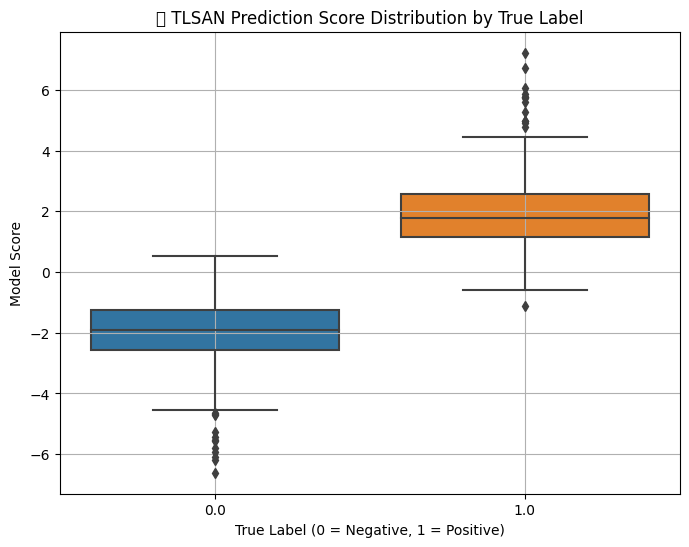

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df_plot = pd.DataFrame({
    'Score': predictions,
    'Label': true_labels
})

plt.figure(figsize=(8, 6))
sns.boxplot(x='Label', y='Score', data=df_plot)
plt.title("TLSAN Prediction Score Distribution by True Label")
plt.xlabel("True Label (0 = Negative, 1 = Positive)")
plt.ylabel("Model Score")
plt.grid(True)
plt.show()


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create DataFrame
df_plot = pd.DataFrame({
    'Score': predictions,
    'Label': true_labels
})

# Plot and save
plt.figure(figsize=(8, 6))
sns.boxplot(x='Label', y='Score', data=df_plot)
plt.title("📦 TLSAN Prediction Score Distribution by True Label")
plt.xlabel("True Label (0 = Negative, 1 = Positive)")
plt.ylabel("Model Score")
plt.grid(True)

# Save the plot
plt.savefig("tlsan_boxplot.png", bbox_inches='tight')
plt.close()

print("✅ Boxplot saved as 'tlsan_boxplot.png'")


✅ Boxplot saved as 'tlsan_boxplot.png'


/tmp/ipykernel_31/328301945.py:20: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.savefig("tlsan_boxplot.png", bbox_inches='tight')


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create DataFrame
df_plot = pd.DataFrame({
    'Score': predictions,
    'Label': true_labels
})

# Plot and save
plt.figure(figsize=(8, 6))
sns.boxplot(x='Label', y='Score', data=df_plot)
plt.title("📦 TLSAN Prediction Score Distribution by True Label")
plt.xlabel("True Label (0 = Negative, 1 = Positive)")
plt.ylabel("Model Score")
plt.grid(True)

# Save the plot
plt.savefig("tlsan_boxplot.png", bbox_inches='tight')
plt.close()

print("✅ Boxplot saved as 'tlsan_boxplot.png'")


✅ Boxplot saved as 'tlsan_boxplot.png'


/tmp/ipykernel_31/328301945.py:20: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.savefig("tlsan_boxplot.png", bbox_inches='tight')


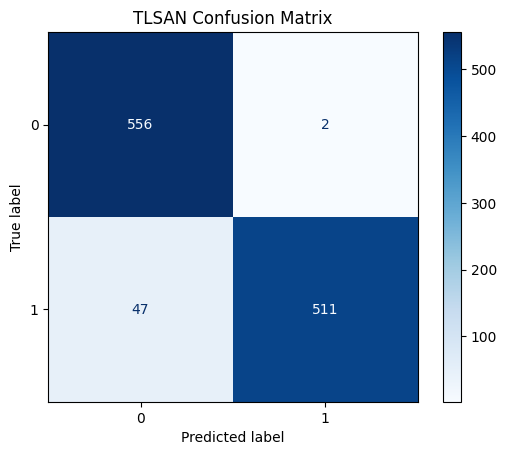

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Convert predicted scores to binary predictions (threshold = 0.5)
pred_labels = (predictions >= 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("TLSAN Confusion Matrix")
plt.grid(False)
plt.show()


In [25]:
from sklearn.metrics import confusion_matrix

# Convert predicted scores to binary predictions (using 0.5 threshold)
pred_labels = (predictions >= 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Print confusion matrix
print("🔢 Confusion Matrix:")
print(cm)

# Optional: labeled output
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives:  {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives:  {tp}")


🔢 Confusion Matrix:
[[556   2]
 [ 47 511]]

True Negatives:  556
False Positives: 2
False Negatives: 47
True Positives:  511


In [26]:
plt.title("TLSAN Confusion Matrix")
plt.grid(False)
plt.savefig("tlsan_confusion_matrix.png", bbox_inches='tight')
plt.close()

print("✅ Confusion matrix saved as 'tlsan_confusion_matrix.png'")


✅ Confusion matrix saved as 'tlsan_confusion_matrix.png'


In [ ]:
import torch
import numpy as np

def precision_at_k(model, dataloader, k, device):
    model.eval()
    precision_list = []

    with torch.no_grad():
        for sequences, pos_items, neg_items in dataloader:
            sequences = sequences.to(device)
            pos_items = pos_items.to(device)
            neg_items = neg_items.to(device)

            # Get model scores for all items (positive items only for this example)
            all_items = torch.arange(0, model.item_embedding.num_embeddings, device=device)  # All possible items
            all_items = all_items.unsqueeze(0).expand(sequences.size(0), -1)  # Expand for batch size

            # Get embeddings for all items and for sequences
            seq_emb = model.item_embedding(sequences)  # (batch_size, seq_len, embed_dim)
            cand_emb = model.item_embedding(all_items)  # (batch_size, num_items, embed_dim)

            # Now calculate the scores (dot product) between the sequence and candidate items
            scores = (seq_emb.mean(dim=1) @ cand_emb.transpose(1, 2))  # (batch_size, num_items)

            # Get top-k predicted items
            _, top_k_indices = torch.topk(scores, k=k, dim=1, largest=True)

            # Check how many of the top-k predicted items are relevant
            relevant_items = torch.isin(top_k_indices, pos_items.unsqueeze(1))  # Check if items in top-k are relevant
            precision = relevant_items.sum().item() / k  # Precision is the number of relevant items divided by k
            precision_list.append(precision)

    avg_precision = np.mean(precision_list)
    return avg_precision

def recall_at_k(model, dataloader, k, device):
    model.eval()
    recall_list = []

    with torch.no_grad():
        for sequences, pos_items, neg_items in dataloader:
            sequences = sequences.to(device)
            pos_items = pos_items.to(device)
            neg_items = neg_items.to(device)

            # Get model scores for all items (positive items only for this example)
            all_items = torch.arange(0, model.item_embedding.num_embeddings, device=device)  # All possible items
            all_items = all_items.unsqueeze(0).expand(sequences.size(0), -1)  # Expand for batch size

            # Get embeddings for all items and for sequences
            seq_emb = model.item_embedding(sequences)  # (batch_size, seq_len, embed_dim)
            cand_emb = model.item_embedding(all_items)  # (batch_size, num_items, embed_dim)

            # Now calculate the scores (dot product) between the sequence and candidate items
            scores = (seq_emb.mean(dim=1) @ cand_emb.transpose(1, 2))  # (batch_size, num_items)

            # Get top-k predicted items
            _, top_k_indices = torch.topk(scores, k=k, dim=1, largest=True)

            # Check how many of the actual positive items are in the top-k
            relevant_items = torch.isin(top_k_indices, pos_items.unsqueeze(1))  # Check if items in top-k are relevant
            recall = relevant_items.sum().item() / len(pos_items)  # Recall is relevant items divided by total positive items
            recall_list.append(recall)

    avg_recall = np.mean(recall_list)
    return avg_recall

# Example: Compute Precision@5 and Recall@5
k = 5
precision_k = precision_at_k(model, dataloader, k, device)
recall_k = recall_at_k(model, dataloader, k, device)

print(f"📏 Precision@{k}: {precision_k:.4f}")
print(f"📏 Recall@{k}: {recall_k:.4f}")


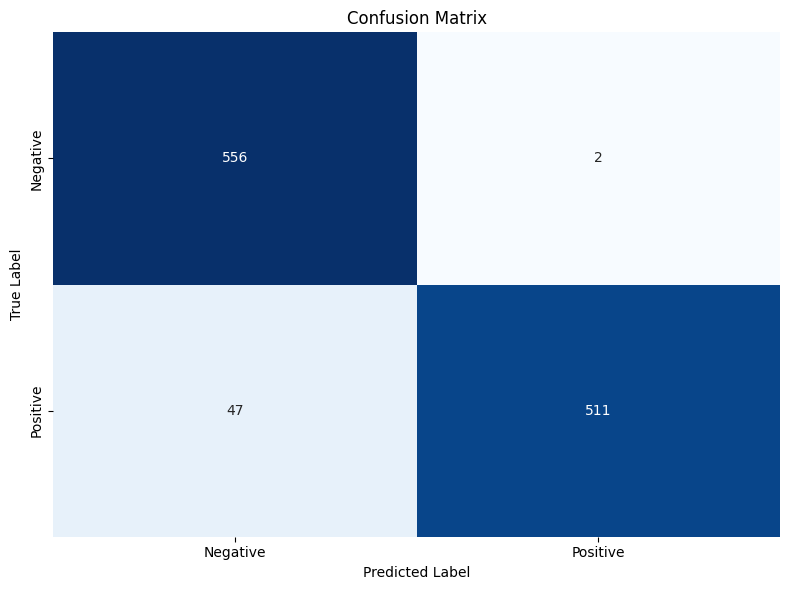

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Manually define your confusion matrix
cm = np.array([[556, 2],
               [47, 511]])

# Step 2: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])

# Step 3: Axis labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()

# Step 4: Save the figure to file
plt.savefig("/kaggle/working/confusion_matrix.png")

# Step 5: Show the plot
plt.show()
